In [1]:
import os 
import cv2
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
#from tensorflow.keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications.inception_v3 import InceptionV3
#from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

In [2]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  # crawls inside folders
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count
train_dir ="tomato_data/train"
test_dir="tomato_data/test"
valid_dir="tomato_data/valid"

In [3]:
 #train file image count
train_samples =get_files(train_dir)
#to get tags
num_classes=len(glob.glob(train_dir+"/*")) 
#test file image count
test_samples=get_files(test_dir)
valid_samples=get_files(valid_dir)

print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")
print(valid_samples,"Validation images")

10 Classes
10000 Train images
1000 Test images
1000 Validation images


In [4]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )
test_datagen=ImageDataGenerator(rescale=1./255)
valid_datagen=ImageDataGenerator(rescale=1./255)

In [5]:
input_shape=(224,224,3)
train_generator =train_datagen.flow_from_directory(train_dir,target_size=(224,224),batch_size=32)
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,target_size=(224,224),batch_size=32)

Found 10000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [6]:
def create_Base_model_from_VGG16():  
    model = VGG16(
        weights = "imagenet",
        include_top=False, 
        input_shape = (224,224, 3) 
        ) 
    for layer in model.layers:
      layer.trainable = False
    return model 
create_Base_model_from_VGG16().summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
def add_custom_layers():
    model = create_Base_model_from_VGG16()
    x = model.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    predictions = tf.keras.layers.Dense(num_classes, activation="softmax")(x)   
    # creating the final model 
    final_model = tf.keras.models.Model(
        inputs = model.input, 
        outputs = predictions)
     
    final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  
    return final_model

add_custom_layers().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
validation_generator = valid_datagen.flow_from_directory(
                       valid_dir,
                       target_size=(224, 224),
                       batch_size=32)

Found 1000 images belonging to 10 classes.


In [9]:
model_from_vgg16 = add_custom_layers()
history = model_from_vgg16.fit(
    train_generator,
    steps_per_epoch=20,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=20,
    verbose=1,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', min_lr=0.0001)],
    use_multiprocessing=False,
    shuffle=True
    )

Epoch 1/30
20/20 [==============================] - 195s 10s/step - loss: 3.4273 - accuracy: 0.3109 - val_loss: 1.4278 - val_accuracy: 0.5484 - lr: 0.0010
Epoch 2/30
20/20 [==============================] - 206s 11s/step - loss: 1.2036 - accuracy: 0.5938 - val_loss: 1.3403 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 3/30
20/20 [==============================] - 201s 10s/step - loss: 1.1778 - accuracy: 0.6125 - val_loss: 1.2169 - val_accuracy: 0.6219 - lr: 0.0010
Epoch 4/30
20/20 [==============================] - 193s 10s/step - loss: 0.8533 - accuracy: 0.6875 - val_loss: 0.8573 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 5/30
20/20 [==============================] - 192s 10s/step - loss: 0.8573 - accuracy: 0.7281 - val_loss: 1.0455 - val_accuracy: 0.6578 - lr: 0.0010
Epoch 6/30
20/20 [==============================] - 206s 11s/step - loss: 0.8673 - accuracy: 0.7094 - val_loss: 1.0867 - val_accuracy: 0.6609 - lr: 0.0010
Epoch 7/30
20/20 [==============================] - 198s 10s/step - lo

In [15]:
model_json = model_from_vgg16.to_json()
with open("vgg16_model3.json", "w") as json_file:
    json_file.write(model_json)
model_from_vgg16.save("vgg16_model3.h5")
print("Saved model to disk")
model_from_vgg16.save_weights("vgg16_weights3.h5")

Saved model to disk


In [16]:
history

In [17]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

print('accuracy','\n',accuracy,'\n')
print('val_accuracy','\n',val_accuracy,'\n')
print('loss','\n',loss,'\n')
print('val_loss','\n',val_loss)

accuracy 
 [0.3109374940395355, 0.59375, 0.612500011920929, 0.6875, 0.7281249761581421, 0.7093750238418579, 0.776562511920929, 0.765625, 0.7875000238418579, 0.784375011920929, 0.7953125238418579, 0.832812488079071, 0.8296874761581421, 0.854687511920929, 0.8374999761581421, 0.8265625238418579, 0.823437511920929, 0.856249988079071, 0.817187488079071, 0.7984374761581421, 0.8453124761581421, 0.8500000238418579, 0.856249988079071, 0.8187500238418579, 0.8500000238418579, 0.8500000238418579, 0.864062488079071, 0.864062488079071, 0.878125011920929, 0.854687511920929] 

val_accuracy 
 [0.5484374761581421, 0.59375, 0.621874988079071, 0.71875, 0.6578124761581421, 0.660937488079071, 0.706250011920929, 0.6812499761581421, 0.75, 0.768750011920929, 0.762499988079071, 0.7984374761581421, 0.78125, 0.7484375238418579, 0.796875, 0.776562511920929, 0.760937511920929, 0.770312488079071, 0.7906249761581421, 0.737500011920929, 0.7562500238418579, 0.800000011920929, 0.7749999761581421, 0.7734375, 0.7703124880

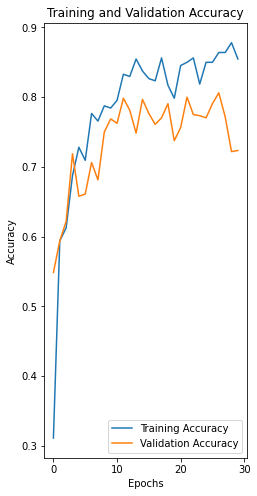

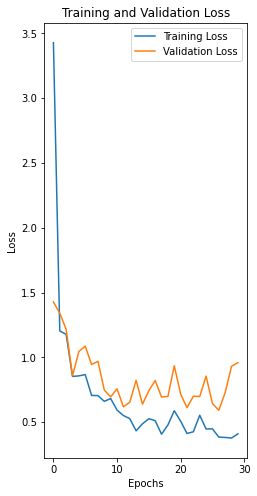

In [18]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(30), accuracy, label='Training Accuracy')
plt.plot(range(30), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()
print("\n")
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 2)
plt.plot(range(30), loss, label='Training Loss')
plt.plot(range(30), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [19]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
model_vgg16=load_model('vgg16_model3.h5')

Bacterial_spot


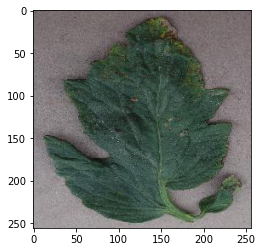

In [22]:
classes=list(train_generator.class_indices.keys())
# Pre-Processing test data same as train data.
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
img_url='tomato_data/test/Bacterial_spot/01a3cf3f-94c1-44d5-8972-8c509d62558e___GCREC_Bact.Sp 3396.JPG'
result_vgg16 = model_vgg16.predict([prepare(img_url)])
disease=image.load_img(img_url)
plt.imshow(disease)

classresult=np.argmax(result_vgg16,axis=1)
print(classes[classresult[0]])